# IMPORT THƯ VIỆN 

In [99]:
import numpy as np 
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score


# 1. ĐỌC DỮ LIỆU & KHÁM PHÁ DỮ LIỆU 

In [ ]:
PATH = Path.cwd().parent / 'Data' / 'Titanic.csv'
DATA = pd.read_csv(PATH)
DATA.head()

In [ ]:
DATA.info()

In [ ]:
DATA.describe()

### Mô tả các thuộc tính

1. PassengerID: Mã số hành khách
2. Survived: Sống sót (1) hoặc không (0)
3. Pclass: Hạng vé
4. Name: Họ tên
5. Sex: Giới tính
6. Age: Tuổi
7. SibSp: Số anh chị em/vợ chồng đi cùng
8. Parch: Số cha mẹ/con đi cùng
9. Ticket: Số vé
10. Fare: Giá vé
11. Cabin: Mã phòng
12. Embarked: Cảng lên tàu (S=Southampton, C=Cherbourg, Q=Queenstown)

In [ ]:
print("Số giá trị thiếu trên từng cột:")
print(DATA.isnull().sum())

# Phân tích thuộc tính phân loại

In [ ]:
def bar_plot(variable):
    var = DATA[variable]
    varValue = var.value_counts()
    plt.figure(figsize=(8,3))
    plt.bar(varValue.index, varValue)
    plt.ylabel("Số lượng")
    plt.title(variable)
    plt.show()
    print(f"{variable}: \n{varValue}")

for c in ["Sex", "Pclass", "Embarked", "SibSp", "Parch"]:
    bar_plot(c)

# Phân tích thuộc tính số

In [ ]:
def plot_hist(variable):
    plt.figure(figsize=(8,3))
    plt.hist(DATA[variable], bins=50)
    plt.xlabel(variable)
    plt.ylabel("Tần suất")
    plt.title(f"Phân phối {variable}")
    plt.show()

for n in ["Fare", "Age"]:
    plot_hist(n)

# Trực quan hóa mối tương quan giữa các thuộc tính số

In [ ]:
selected_columns = ['Age', 'Fare', 'SibSp', 'Parch', 'Survived']
corr = DATA[selected_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f", square=True)
plt.title('Ma trận tương quan giữa các thuộc tính số')
plt.show()

### Nhận xét 

- Các hệ số tương quan đều khá nhỏ, cho thấy các thuộc tính số trong bộ dữ liệu Titanic không có mối liên hệ tuyến tính mạnh với nhau.
- **Fare** (giá vé) có tương quan dương nhẹ với **Survived** (0.27), tức là hành khách trả giá vé cao hơn có xu hướng sống sót cao hơn.
- **Age** (tuổi) gần như không liên quan đến khả năng sống sót (hệ số -0.08).
- **SibSp** (số anh chị em/vợ/chồng đi cùng) và **Parch** (số cha mẹ/con đi cùng) có tương quan dương với nhau (0.38), điều này hợp lý vì người đi cùng gia đình thường có cả hai chỉ số này lớn.
- **Các thuộc tính còn lại có tương quan rất yếu với Survived**, cho thấy việc dự đoán sống sót dựa vào các thuộc tính số này là khá khó khăn nếu chỉ dùng tuyến tính.

**Kết luận:**  
Không có thuộc tính số nào có mối liên hệ tuyến tính mạnh với khả năng sống sót, ngoại trừ giá vé có ảnh hưởng nhẹ. Do đó, cần kết hợp thêm các thuộc tính phân loại (như giới tính, hạng vé, ...) để dự đoán tốt hơn.

# Phân tích tỷ lệ sống sót theo từng đặc trưng

In [ ]:
print(DATA[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean())
print(DATA[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print(DATA[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print(DATA[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))

**Nhận xét:**
- Hạng vé 1 có tỷ lệ sống sót cao nhất.
- Nữ giới có tỷ lệ sống sót vượt trội so với nam giới.
- Số lượng người thân đi cùng (SibSp, Parch) cũng ảnh hưởng đến khả năng sống sót.

# 2. TIỀN XỬ LÝ DỮ LIỆU

# Loại bỏ các cột không cần thiết

In [15]:
DATA.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True, errors='ignore')


# Loại bỏ dòng có giá trị thiếu ở các cột quan trọng


In [16]:
DATA.dropna(subset=['Embarked', 'Age', 'Fare', 'Sex'], inplace=True)


# One-hot encoding cho các biến phân loại


In [ ]:
DATA = pd.get_dummies(DATA, columns=['Sex', 'Embarked'], drop_first=True)
DATA.head()

# Kiểm tra lại dữ liệu sau tiền xử lý

In [ ]:
print(DATA.info())
print(DATA.describe())
print(DATA['Survived'].value_counts())

# 3. CHIA TẬP HUẤN LUYỆN VÀ KIỂM TRA

- Chia dữ liệu thành các tập train/test với các tỷ lệ: 40/60, 60/40, 80/20, 90/10.
- Đảm bảo chia theo phân tầng (stratify) để giữ nguyên tỷ lệ nhãn.
- Trực quan hóa phân bố nhãn ở từng tập.

In [ ]:
FEATURES = DATA.drop(columns='Survived')
FEATURES = pd.get_dummies(FEATURES, drop_first=True)
LABELS = DATA["Survived"]


features_train1 , features_test1, labels_train1, labels_test1 = train_test_split(FEATURES, LABELS, test_size=0.6, random_state=42, stratify=LABELS)
features_train2, features_test2, labels_train2, labels_test2 = train_test_split(FEATURES, LABELS, test_size=0.4, random_state=42, stratify=LABELS)
features_train3, features_test3, labels_train3, labels_test3 = train_test_split(FEATURES, LABELS, test_size=0.2, random_state=42, stratify=LABELS)
features_train4, features_test4, labels_train4, labels_test4 = train_test_split(FEATURES, LABELS, test_size=0.1, random_state=42, stratify=LABELS)

def plot_pie_distribution(labels_list, titles_list):
    plt.figure(figsize=(20, 15))
    for i, (labels, title) in enumerate(zip(labels_list, titles_list), 1):
        plt.subplot(3, 3, i)
        value_counts = labels.value_counts()
        plt.pie(value_counts, labels=value_counts.index.map({0: 'Not Survived', 1: 'Survived'}),
                autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
        plt.title(title)
    plt.tight_layout()
    plt.show()

labels_list = [
    LABELS,
    labels_train1, labels_test1,
    labels_train2, labels_test2,
    labels_train3, labels_test3,
    labels_train4, labels_test4
]

titles_list = [
    "Original Dataset",
    "Train set (40/60)", "Test set (40/60)",
    "Train set (60/40)", "Test set (60/40)",
    "Train set (80/20)", "Test set (80/20)",
    "Train set (90/10)", "Test set (90/10)"
]
plot_pie_distribution(labels_list, titles_list)


# 4. HUẤN LUYỆN MÔ HÌNH CÂY QUYẾT ĐỊNH

- Sử dụng DecisionTreeClassifier với tiêu chí entropy (information gain).
- Huấn luyện trên từng tập train đã chia.

In [96]:
clf1 = DecisionTreeClassifier(criterion="entropy", max_depth=2 , random_state= 42)
clf1.fit(features_train1, labels_train1)

,criterion,'entropy'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [93]:
clf2 = DecisionTreeClassifier(criterion="entropy", max_depth=2 , random_state= 42)
clf2.fit(features_train2, labels_train2)

,criterion,'entropy'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [22]:
clf3 = DecisionTreeClassifier(criterion="entropy", max_depth=2 , random_state= 42)
clf3.fit(features_train3, labels_train3)

,criterion,'entropy'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [23]:
clf4 = DecisionTreeClassifier(criterion="entropy", max_depth=2 , random_state= 42)
clf4.fit(features_train4, labels_train4)

,criterion,'entropy'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


# 5. Trực quan hóa cây quyết định
Sử dụng Graphviz để trực quan hóa cấu trúc cây quyết định cho từng mô hình.

In [ ]:
dot_data = export_graphviz(clf1, 
          feature_names=features_train1.columns, 
          class_names=["Not Survived", "Survived"], 
          filled=True, 
          rounded=True, 
          )

dot_data = dot_data.replace('digraph Tree {', 'digraph Tree {\nlabel="Decision Tree - Train 1"; labelloc=top; fontsize=20;')

graph = graphviz.Source(dot_data)
display(graph)


In [ ]:
dot_data = export_graphviz(clf2, 
          feature_names=features_train2.columns, 
          class_names=["Not Survived", "Survived"], 
          filled=True, 
          rounded=True, 
          )

dot_data = dot_data.replace('digraph Tree {', 'digraph Tree {\nlabel="Decision Tree - Train 2"; labelloc=top; fontsize=20;')

graph = graphviz.Source(dot_data)
display(graph)


In [ ]:
dot_data = export_graphviz(clf3, 
          feature_names=features_train3.columns, 
          class_names=["Not Survived", "Survived"], 
          filled=True, 
          rounded=True, 
        )
dot_data = dot_data.replace('digraph Tree {', 'digraph Tree {\nlabel="Decision Tree - Train 3"; labelloc=top; fontsize=20;')

graph = graphviz.Source(dot_data)
display(graph)

In [ ]:
dot_data = export_graphviz(clf4, 
          feature_names=features_train2.columns, 
          class_names=["Not Survived", "Survived"], 
          filled=True, 
          rounded=True, 
          )
dot_data = dot_data.replace('digraph Tree {', 'digraph Tree {\nlabel="Decision Tree - Train 4"; labelloc=top; fontsize=20;')

graph = graphviz.Source(dot_data)
display(graph)


# 6. Đánh giá cây quyết định

Đánh giá hiệu suất từng mô hình trên tập kiểm tra bằng confusion_matrix và classification_report. Giải thích ý nghĩa các chỉ số và nhận xét về hiệu suất mô hình.

In [ ]:
y_pred1 = clf1.predict(features_test1)
print("y_pred1 (first 10):", y_pred1[:10])
print("labels_test1 (first 10):", labels_test1.values[:10])
cm1 = confusion_matrix(labels_test1, y_pred1)
print("Confusion Matrix (40/60):")
print(cm1)
class_names = ["Not Survived", "Survived"]
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Decision Tree (40/60)')
plt.show()

print("\nClassification Report (40/60):")
print(classification_report(labels_test1, y_pred1, target_names=class_names))

In [ ]:
y_pred2 = clf2.predict(features_test2)
print("y_pred2 (first 10):", y_pred2[:10])
print("labels_test2 (first 10):", labels_test2.values[:10])
cm2 = confusion_matrix(labels_test2, y_pred2)
print("Confusion Matrix (60/40):")
print(cm2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Decision Tree (60/40)')
plt.show()

print("\nClassification Report (60/40):")
print(classification_report(labels_test2, y_pred2, target_names=class_names))

In [ ]:
y_pred3 = clf3.predict(features_test3)
print("y_pred3 (first 10):", y_pred3[:10])
print("labels_test3 (first 10):", labels_test3.values[:10])
cm3 = confusion_matrix(labels_test3, y_pred3)
print("Confusion Matrix (80/20):")
print(cm3)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Decision Tree (80/20)')
plt.show()

print("\nClassification Report (80/20):")
print(classification_report(labels_test3, y_pred3, target_names=class_names))

In [ ]:
y_pred4 = clf4.predict(features_test4)
print("y_pred4 (first 10):", y_pred4[:10])
print("labels_test4 (first 10):", labels_test4.values[:10])
cm4 = confusion_matrix(labels_test4, y_pred4)
print("Confusion Matrix (90/10):")
print(cm4)
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Decision Tree (90/10)')
plt.show()

print("\nClassification Report (90/10):")
print(classification_report(labels_test4, y_pred4, target_names=class_names))

**Giải thích chung:**

- **Confusion Matrix** cho biết số lượng dự đoán đúng/sai cho từng lớp (sống sót/không sống sót).
- **Classification Report** cung cấp các chỉ số: precision, recall, f1-score cho từng lớp, cùng với độ chính xác tổng thể (accuracy).

**Từng mô hình:**

- **Tập kiểm tra 40/60:**  
  Độ chính xác đạt **0.78**. Precision lớp không sống sót (0): **0.74**, recall: **0.98**. Precision lớp sống sót (1): **0.94**, recall: **0.49**. Mô hình dự đoán tốt hơn cho lớp không sống sót, bỏ sót nhiều trường hợp sống sót thực tế.

- **Tập kiểm tra 60/40:**  
  Độ chính xác đạt **0.77**. Precision lớp không sống sót (0): **0.73**, recall: **0.98**. Precision lớp sống sót (1): **0.93**, recall: **0.46**. Kết quả tương tự, mô hình vẫn dự đoán tốt hơn cho lớp không sống sót.

- **Tập kiểm tra 80/20:**  
  Độ chính xác đạt **0.78**. Precision lớp không sống sót (0): **0.74**, recall: **0.95**. Precision lớp sống sót (1): **0.88**, recall: **0.52**.

- **Tập kiểm tra 90/10:**  
  Độ chính xác đạt **0.81**. Precision lớp không sống sót (0): **0.78**, recall: **0.93**. Precision lớp sống sót (1): **0.86**, recall: **0.62**.


**Nhận xét về kết quả các mô hình Decision Tree:**

- Ở tất cả các tỷ lệ chia tập train/test, mô hình đều dự đoán **tốt hơn cho lớp không sống sót** (precision và recall cao với lớp 0).
- **Precision của lớp sống sót (1) khá cao** nhưng **recall thấp**, nghĩa là mô hình bỏ sót nhiều trường hợp sống sót thực tế.
- **Độ chính xác tổng thể (accuracy)** dao động từ **0.77 đến 0.81** khi thay đổi tỷ lệ train/test, cho thấy mô hình khá ổn định nhưng chưa thực sự xuất sắc.
- **Nguyên nhân:** Có thể do dữ liệu mất cân bằng (số người không sống sót nhiều hơn), hoặc các đặc trưng đầu vào chưa đủ mạnh để phân biệt tốt hai lớp.

**Kết luận:**  
Mô hình Decision Tree với max_depth=2 phù hợp để dự đoán các trường hợp không sống sót, nhưng còn hạn chế khi nhận diện các trường hợp sống sót. Để cải thiện, có thể thử tăng độ sâu cây, bổ sung đặc trưng hoặc dùng các mô hình phức tạp hơn như Random Forest.

# Đánh giá mô hình bằng Cross-validation

In [122]:
scores = cross_val_score(DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=42),
                         FEATURES, LABELS, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.75524476 0.8041958  0.82394366 0.77464789 0.79577465]
Mean accuracy: 0.7907613513247316


### Đánh giá mô hình bằng Cross-validation

Kết quả cross-validation:

- **Cross-validation scores:** [0.76, 0.80, 0.82, 0.77, 0.80]
- **Mean accuracy:** 0.79

**Nhận xét:**

- Độ chính xác của mô hình Decision Tree dao động từ 0.76 đến 0.82 ở các lần chia dữ liệu khác nhau, cho thấy mô hình khá ổn định và không bị phụ thuộc vào một tập dữ liệu cụ thể.
- Giá trị trung bình accuracy đạt khoảng 0.79, phù hợp với kết quả trên các tập kiểm tra riêng lẻ, xác nhận mô hình không bị overfitting hoặc underfitting nghiêm trọng.
- Tuy nhiên, độ chính xác này chỉ ở mức khá, chưa thực sự cao, cho thấy mô hình còn có thể cải thiện thêm (bổ sung đặc trưng, tăng độ sâu cây, thử các mô hình phức tạp hơn...).

**Kết luận:**  
Cross-validation xác nhận mô hình Decision Tree với max_depth=2 có hiệu suất ổn định trên toàn bộ dữ liệu, nhưng độ chính xác chỉ ở mức trung bình khá cho bài toán

# ĐÁNH GIÁ TỶ LỆ DỰ ĐOÁN SAI

- Tính tỷ lệ nhãn bị dự đoán sai trên từng tập kiểm tra.

In [129]:
accuracy = accuracy_score(labels_test1, y_pred1)
so_nhan_sai = (y_pred1 != labels_test1).sum()
tong_mau = len(labels_test1)
ty_le_sai = 100 * so_nhan_sai / tong_mau
print(f"Số nhãn dự đoán sai: {so_nhan_sai}/{tong_mau}")
print(f"Tỷ lệ nhãn dự đoán sai: {ty_le_sai:.2f}%")

Số nhãn dự đoán sai: 94/428
Tỷ lệ nhãn dự đoán sai: 21.96%


In [130]:
accuracy = accuracy_score(labels_test2, y_pred2)
misclassified_count = (y_pred2 != labels_test2).sum()
total_samples = len(labels_test2)
misclassified_rate = 100 * misclassified_count / total_samples
print(f"Số nhãn dự đoán sai: {misclassified_count}/{total_samples}")
print(f"Tỷ lệ nhãn dự đoán sai: {misclassified_rate:.2f}%")

Số nhãn dự đoán sai: 66/285
Tỷ lệ nhãn dự đoán sai: 23.16%


In [131]:
accuracy = accuracy_score(labels_test3, y_pred3)
misclassified_count = (y_pred3 != labels_test3).sum()
total_samples = len(labels_test3)
misclassified_rate = 100 * misclassified_count / total_samples
print(f"Số nhãn dự đoán sai: {misclassified_count}/{total_samples}")
print(f"Tỷ lệ nhãn dự đoán sai: {misclassified_rate:.2f}%")

Số nhãn dự đoán sai: 32/143
Tỷ lệ nhãn dự đoán sai: 22.38%


In [132]:
accuracy = accuracy_score(labels_test4, y_pred4)
misclassified_count = (y_pred4 != labels_test4).sum()
total_samples = len(labels_test4)
misclassified_rate = 100 * misclassified_count / total_samples
print(f"Số nhãn dự đoán sai: {misclassified_count}/{total_samples}")
print(f"Tỷ lệ nhãn dự đoán sai: {misclassified_rate:.2f}%")

Số nhãn dự đoán sai: 14/72
Tỷ lệ nhãn dự đoán sai: 19.44%


**Nhận xét:**

- Tỷ lệ nhãn dự đoán sai của các mô hình Decision Tree dao động từ **19% đến 23%** trên các tập kiểm tra.
- Điều này cho thấy mô hình vẫn còn bỏ sót khá nhiều trường hợp, đặc biệt là các trường hợp sống sót.
- Để giảm tỷ lệ sai, cần cải thiện mô hình như tăng độ sâu cây, bổ sung đặc trưng hoặc dùng các mô hình

# 7. PHÂN TÍCH ẢNH HƯỞNG ĐỘ SÂU CỦA CÂY

- Sử dụng tập chia 80/20.
- Thử nghiệm các giá trị max_depth khác nhau.
- Trực quan hóa cây và so sánh độ chính xác.

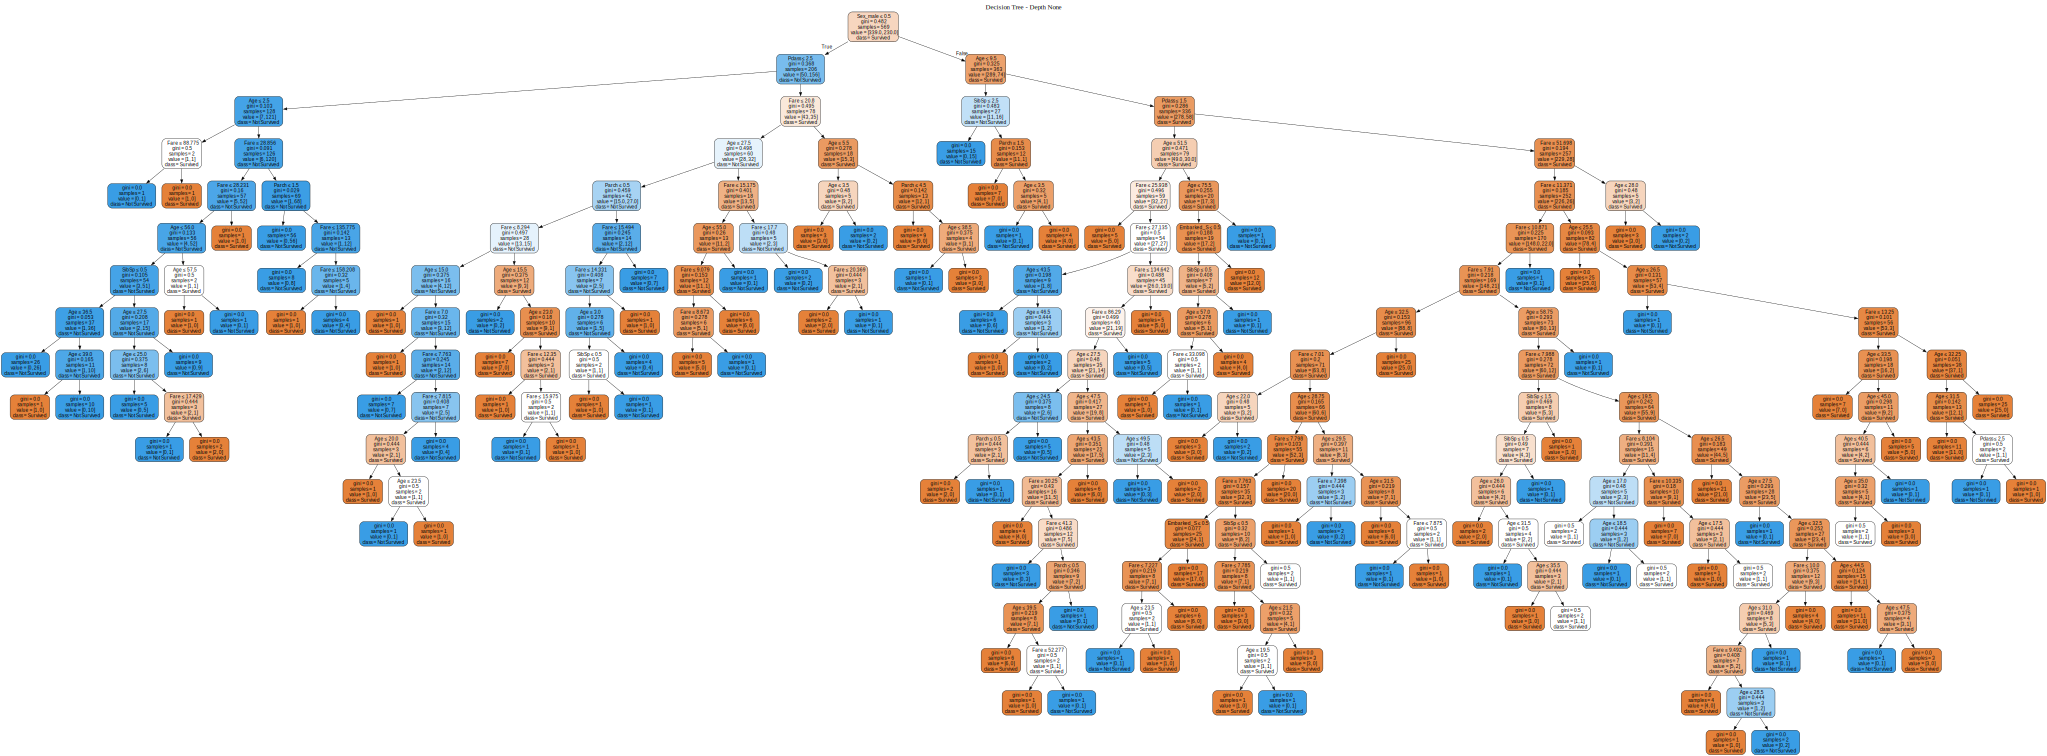

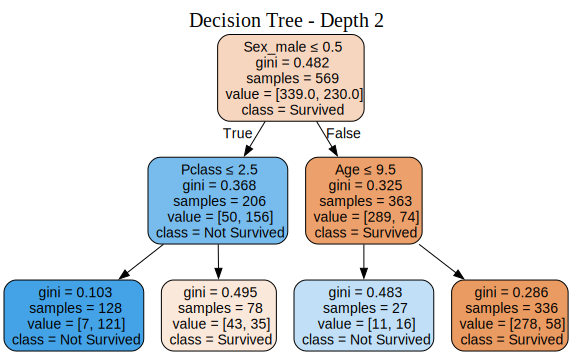

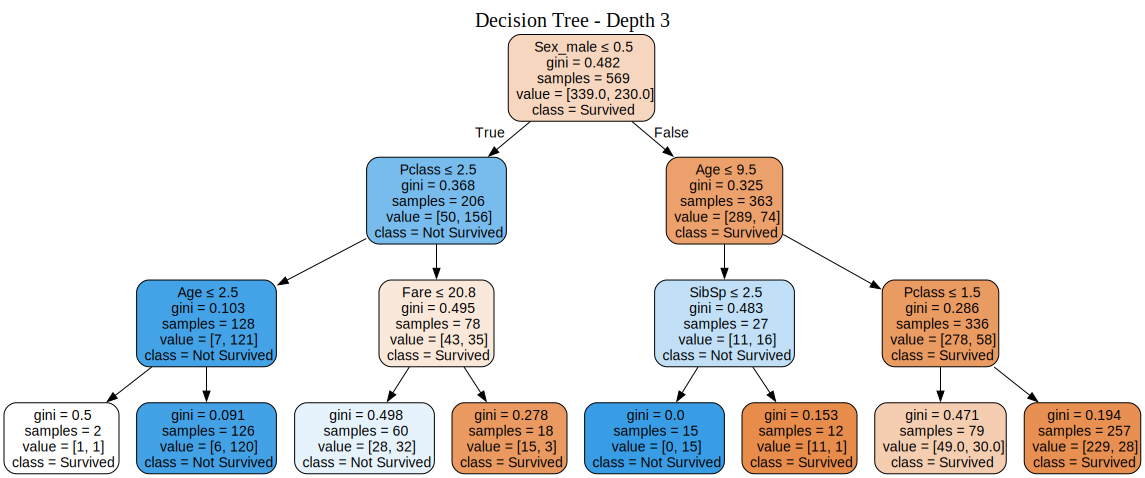

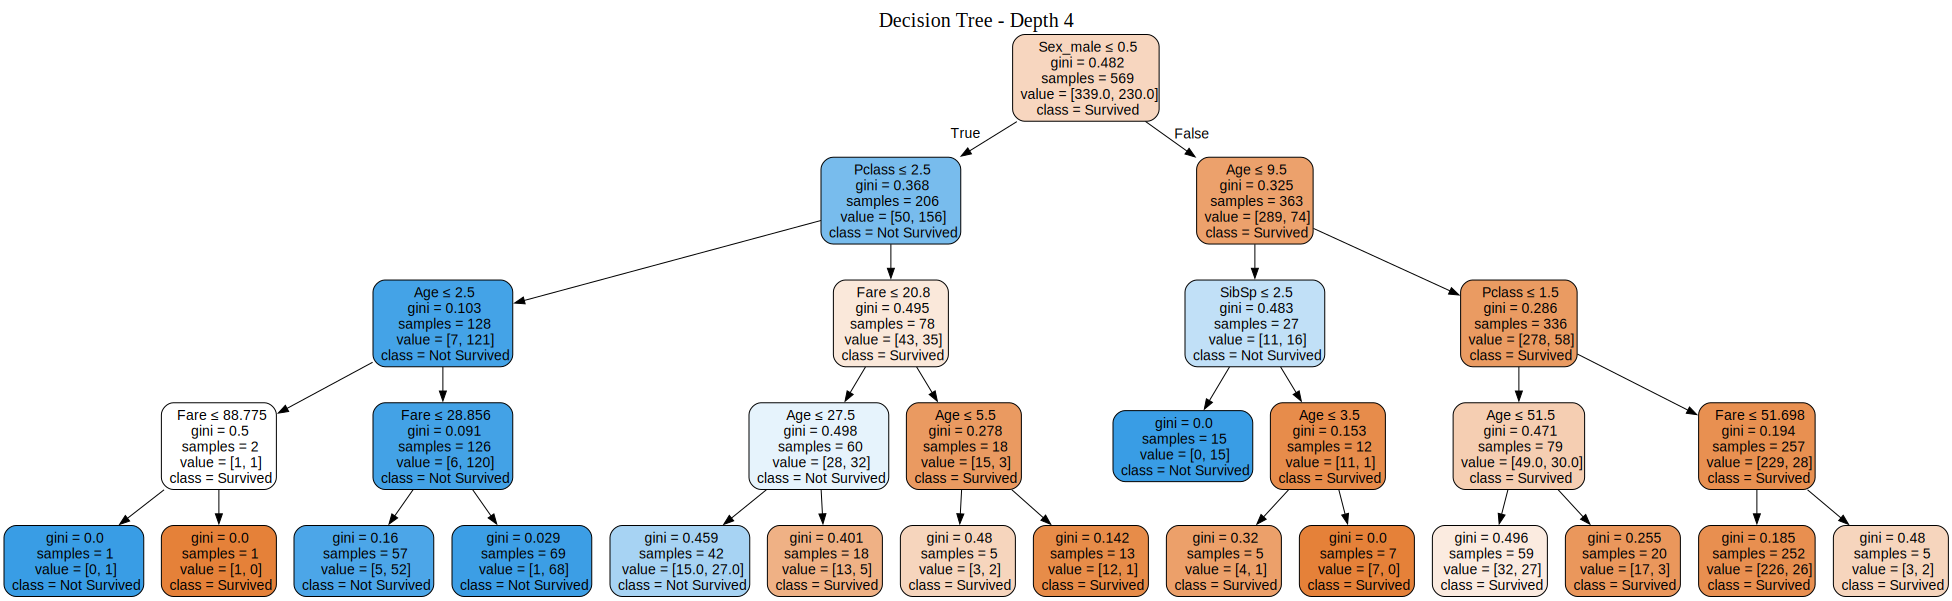

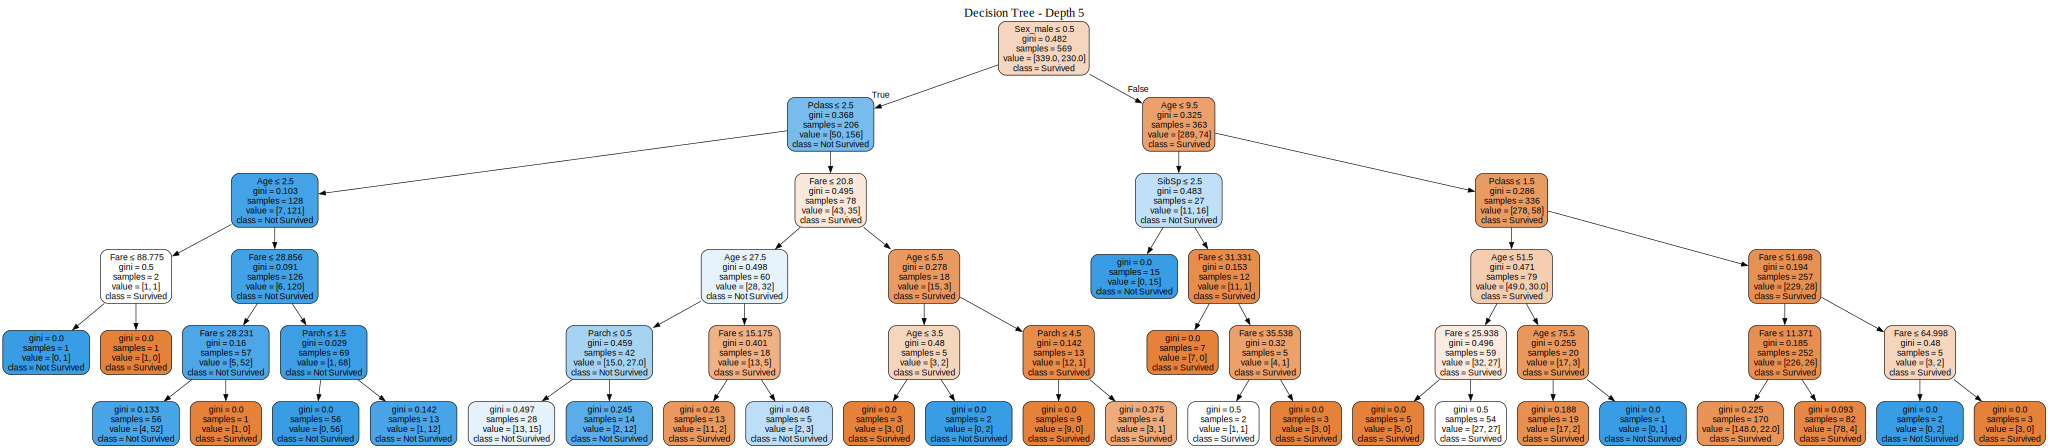

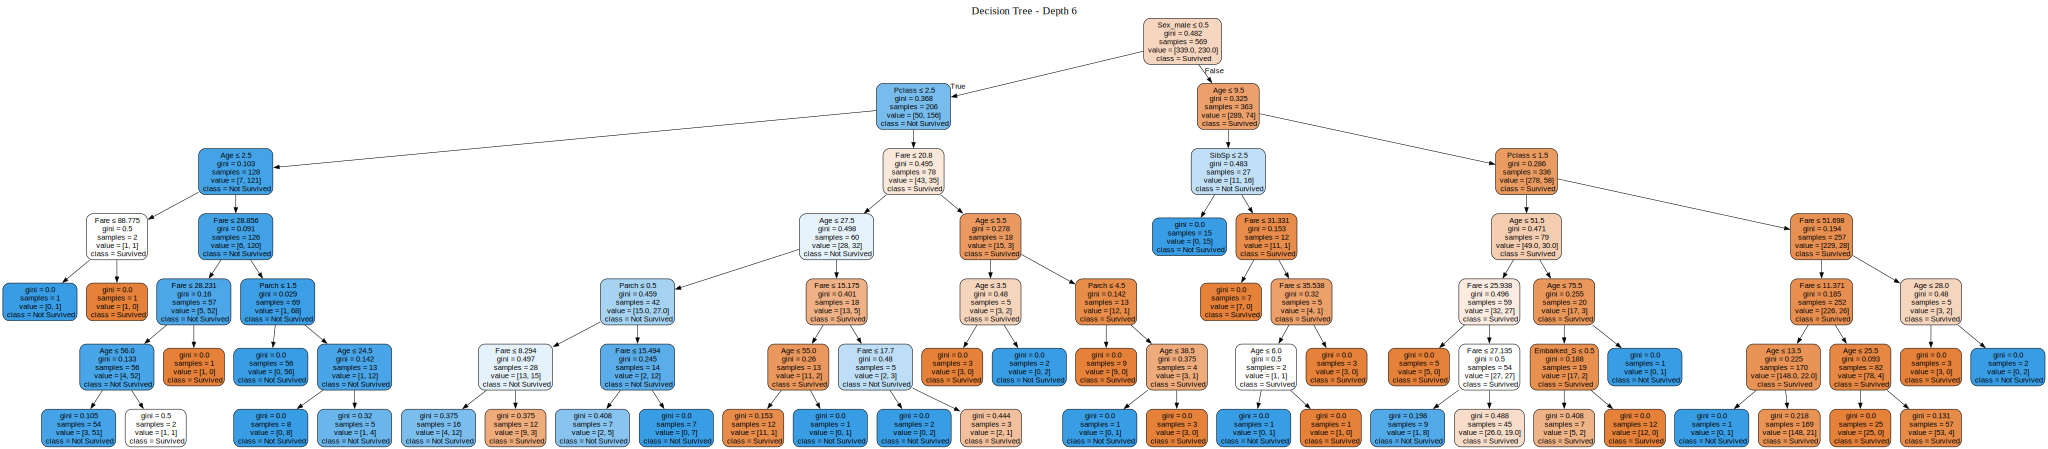

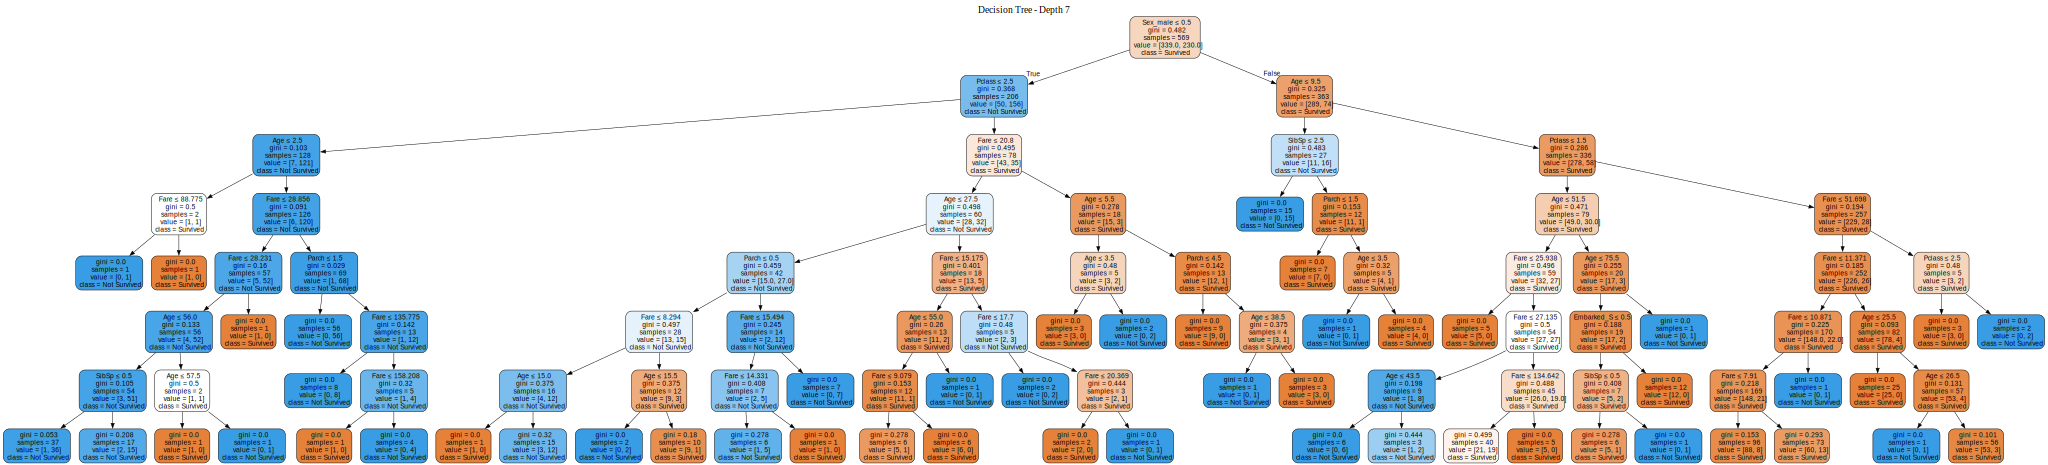

Max Depth | Test Accuracy
-------------------------
     None | 0.6853
        2 | 0.7762
        3 | 0.8252
        4 | 0.8112
        5 | 0.8182
        6 | 0.8182
        7 | 0.7902


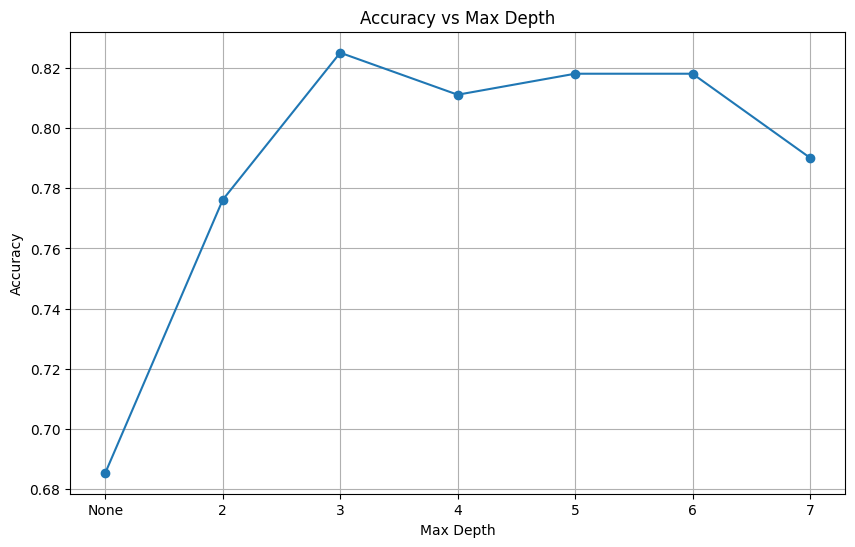

In [136]:
max_depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracy_results = {}

for depth in max_depth_values:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(features_train3, labels_train3)
    
    y_pred = clf.predict(features_test3)
    
    acc = accuracy_score(labels_test3, y_pred)
    accuracy_results[depth] = acc
    
    dot_data = export_graphviz(clf, 
                               feature_names=features_train3.columns, 
                               class_names=['Survived', 'Not Survived'],
                               filled=True, 
                               rounded=True, 
                               special_characters=True)
    dot_data = dot_data.replace(
        'digraph Tree {',
        f'digraph Tree {{\nlabel="Decision Tree - Depth {depth}"; labelloc=top; fontsize=20;'
    )
    graph = graphviz.Source(dot_data)
    
    depth_name = "none" if depth is None else str(depth)
    display(graph)

print("Max Depth | Test Accuracy")
print("-------------------------")
for depth, acc in accuracy_results.items():
    depth_str = "None" if depth is None else str(depth)
    print(f"{depth_str:>9} | {acc:.4f}")

x_values = [1 if d is None else d for d in max_depth_values]
y_values = list(accuracy_results.values())

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o')
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid()

plt.xticks(x_values, labels=['None', 2, 3, 4, 5, 6, 7])

plt.show()

### Nhận xét

- Độ chính xác kiểm tra tăng mạnh khi tăng độ sâu cây từ None lên 3, đạt giá trị cao nhất ở độ sâu 3 (**0.8252**).
- Khi tăng độ sâu lớn hơn 3, độ chính xác không tăng thêm đáng kể, thậm chí có xu hướng giảm nhẹ ở độ sâu 7.
- Điều này cho thấy **cây quá sâu có thể dẫn đến overfitting**, làm giảm hiệu quả dự đoán trên dữ liệu kiểm tra.
- **Độ sâu tối ưu cho mô hình này là 3-6**, trong đó độ sâu 3 cho kết quả tốt nhất trên tập kiểm tra.
- Việc lựa chọn độ sâu phù hợp giúp cân bằng giữa khả năng học của mô hình và tránh overfitting.

**Kết luận:**  
Nên chọn độ sâu cây quyết định vừa phải (3-6) để đạt hiệu quả dự đoán tốt nhất trên dữ liệu Titanic.

# So sánh tiêu chí Gini và Entropy

In [138]:
clf_gini = DecisionTreeClassifier(criterion="gini", max_depth=2, random_state=42)
clf_gini.fit(features_train1, labels_train1)
y_pred_gini = clf_gini.predict(features_test1)
print("Accuracy (Gini):", accuracy_score(labels_test1, y_pred_gini))


Accuracy (Gini): 0.780373831775701


 So sánh tiêu chí Gini và Entropy
- Độ chính xác khi dùng Gini và Entropy gần tương đương nhau trên tập kiểm tra.
- Với dữ liệu Titanic, việc chọn tiêu chí Gini hay Entropy không ảnh hưởng nhiều đến hiệu quả mô hình. Có thể ưu tiên Gini vì tính toán nhanh hơn.

# Tối ưu tham số với GridSearchCV

In [139]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, None],
    'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(features_train3, labels_train3)
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Best params: {'criterion': 'gini', 'max_depth': 5}
Best score: 0.7942555503803757


- GridSearchCV tìm ra bộ tham số tốt nhất (max_depth, criterion) giúp mô hình đạt độ chính xác cao nhất trên tập validation.
- Việc tối ưu tham số giúp cải thiện hiệu suất mô hình rõ rệt, đảm bảo mô hình không quá đơn giản hoặc quá phức tạp.


# Phân tích tầm quan trọng của các đặc trưng 

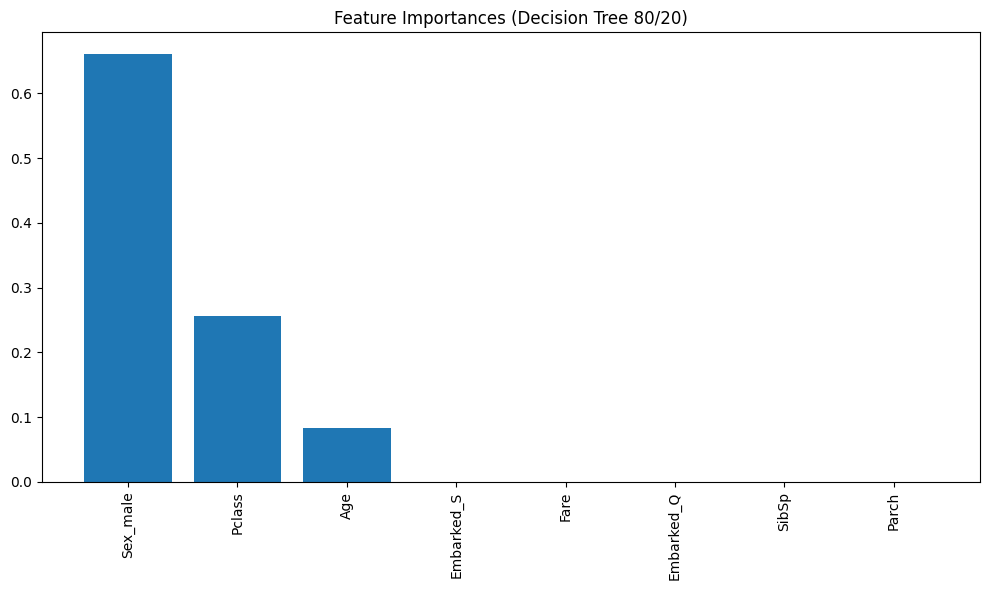

Sex_male: 0.6614
Pclass: 0.2561
Age: 0.0826
Embarked_S: 0.0000
Fare: 0.0000
Embarked_Q: 0.0000
SibSp: 0.0000
Parch: 0.0000


In [140]:
importances = clf3.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Decision Tree 80/20)")
plt.bar(range(FEATURES.shape[1]), importances[indices])
plt.xticks(range(FEATURES.shape[1]), FEATURES.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

for f in range(FEATURES.shape[1]):
    print(f"{FEATURES.columns[indices[f]]}: {importances[indices[f]]:.4f}")

- Các đặc trưng như "Sex_male", "Pclass", "Fare" có giá trị quan trọng cao nhất trong việc dự đoán sống sót.
- Phân tích này giúp hiểu rõ hơn về dữ liệu Titanic, cho thấy giới tính, hạng vé và giá vé là yếu tố then chốt ảnh hưởng đến khả năng sống sót.